# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [2]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
from ounoise import OUNoise
from model import Actor, Critic
from replay_buffer import ReplayBuffer

from utils import create_agent, plot_scores

In [5]:
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [9]:
agent = create_agent(env, brain_name, device, actor_file=None, critic_file=None, random_seed=39, lr_actor=LR_ACTOR,
                           lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, buffer_size=BUFFER_SIZE,
                           batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU)

Initilized Actor with state size 33 and action size 4
Initilized Actor with state size 33 and action size 4
Initilized Critic with state size 33 and action size 4
Initilized Critic with state size 33 and action size 4
Initilized agent with state size = 33 and action size = 4


In [10]:
def ddpg(n_episodes=500, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    max_score = -np.Inf

    for i_episode in range(1, n_episodes + 1):
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        # Reset agent
        agent.reset()
        # Get the initial state
        state = env_info.vector_observations[0]
        # Reassign score to 0
        score = 0

        for t in range(max_t):
            # Get action
            action = agent.act(state)
            # Observe reaction (environment)
            env_info = env.step(action)[brain_name]
            ## Get new state
            next_state = env_info.vector_observations[0]
            ## Get reward
            reward = env_info.rewards[0]
            # See if episode has finished
            done = env_info.local_done[0]
            # Step
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                break

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")

        scores_deque.append(score)
        scores.append(score)
        max_score = max(max_score, score)

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMax score: {:.2f}'.format(i_episode, np.mean(scores_deque),
                                                                                  max_score), end="")
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')

    return scores

In [11]:
scores = ddpg()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 500	Average Score: 35.90	Max score: 39.55

In [12]:
env.close()

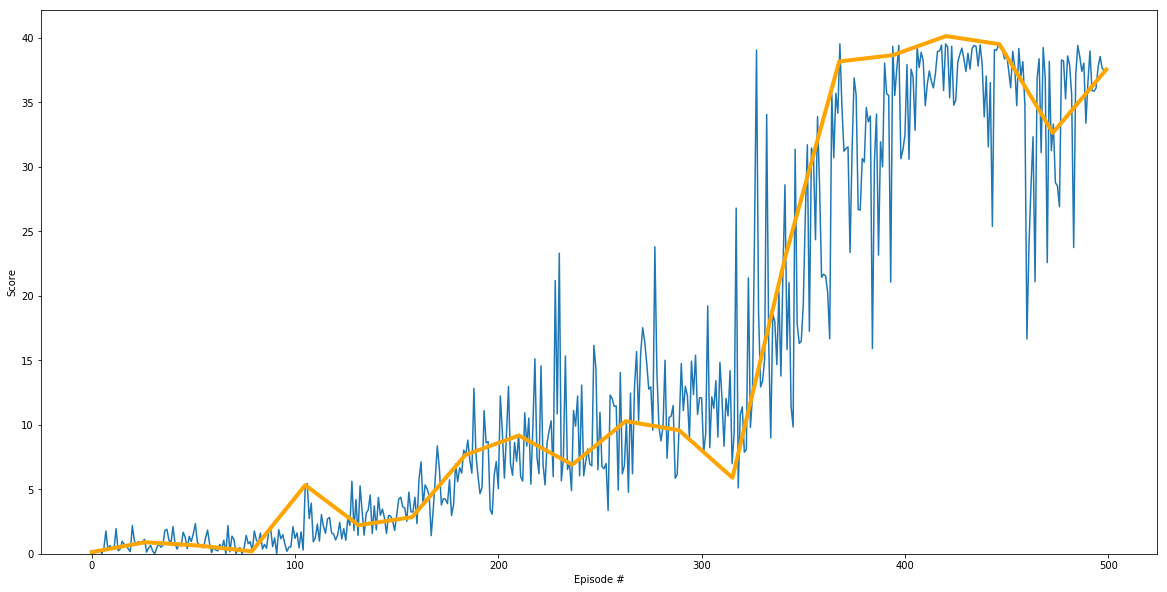

In [13]:
plot_scores(scores)

As the plot shown the agent rouhgly took 350 episodes to cross a score of 30 and then maintained that for rest of the ~ 150 episodes.